In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Reshape, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [4]:
def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((5194, 32, 32, 1), (917, 32, 32, 1))

In [5]:
x_train.shape

(5194, 32, 32, 1)

In [6]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)

    for i in range(5):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 4)    40          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    20          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 8)    0           <tensorflow.python.keras.layers.c
                                     

In [7]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 5194 samples, validate on 917 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
5194/5194 [==============================] - 1s 252us/sample - loss: 88.8274 - val_loss: 87.5460
Epoch 2/100
5194/5194 [==============================] - 1s 99us/sample - loss: 88.6237 - val_loss: 87.3637
Epoch 3/100
5194/5194 [==============================] - 1s 99us/sample - loss: 88.4667 - val_loss: 87.2375
Epoch 4/100
5194/5194 [==============================] - 1s 100us/sample - loss: 88.3579 - val_loss: 87.1458
Epoch 5/100
5194/5194 [==============================] - 1s 98us/sample - loss: 88.2785 - val_loss: 87.0801
Epoch 6/100
5194/5194 [==============================] - 1s 99us/sample - loss: 88.2197 - val_loss: 87.0294
Epoch 7/100
5194/5194 [==============================] - 1s 99us/sample - loss: 88.1737 - val_loss: 86.9884
Epoch 8/100
5194/5194 [==============================] - 1s 98us/sample - loss: 88.1348 - val_loss: 86.9514
Epoch 9/100
5194/5194 [================

5194/5194 [==============================] - 1s 98us/sample - loss: 62.3177 - val_loss: 61.0371
Epoch 74/100
5194/5194 [==============================] - 1s 98us/sample - loss: 62.2998 - val_loss: 61.0730
Epoch 75/100
5194/5194 [==============================] - 1s 97us/sample - loss: 62.2888 - val_loss: 61.0919
Epoch 76/100
5194/5194 [==============================] - 1s 97us/sample - loss: 62.2850 - val_loss: 61.0931
Epoch 77/100
5194/5194 [==============================] - 1s 98us/sample - loss: 62.2813 - val_loss: 61.0365
Epoch 78/100
5194/5194 [==============================] - 1s 98us/sample - loss: 62.2966 - val_loss: 61.0568
Epoch 79/100
5194/5194 [==============================] - 1s 99us/sample - loss: 62.2738 - val_loss: 61.0254
Epoch 80/100
5194/5194 [==============================] - 1s 98us/sample - loss: 62.2767 - val_loss: 60.9940
Epoch 81/100
5194/5194 [==============================] - 1s 99us/sample - loss: 62.2690 - val_loss: 61.0946
Epoch 82/100
5194/5194 [========

In [8]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

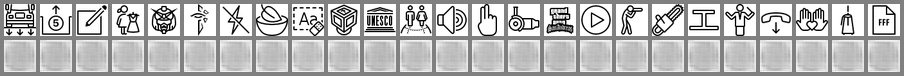

In [9]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [10]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)


In [11]:
x_train_aug = augment(x_train)
x_test_aug = augment(x_test)

In [12]:
x_train_aug.shape

(83104, 32, 32, 1)

In [13]:
from tensorflow.keras.callbacks import TensorBoard
autoencoder = create_autoencoder()
autoencoder.fit(x_train_aug, x_train_aug,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_aug, x_test_aug),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 83104 samples, validate on 14672 samples
Epoch 1/100
83104/83104 [==============================] - 9s 103us/sample - loss: 73.7913 - val_loss: 63.6779
Epoch 2/100
83104/83104 [==============================] - 8s 98us/sample - loss: 63.3031 - val_loss: 62.5157
Epoch 3/100
83104/83104 [==============================] - 8s 97us/sample - loss: 62.8244 - val_loss: 62.3075
Epoch 4/100
83104/83104 [==============================] - 8s 98us/sample - loss: 62.6942 - val_loss: 62.2236
Epoch 5/100
83104/83104 [==============================] - 8s 97us/sample - loss: 62.6249 - val_loss: 62.1623
Epoch 6/100
83104/83104 [==============================] - 8s 99us/sample - loss: 62.5673 - val_loss: 62.1035
Epoch 7/100
83104/83104 [==============================] - 8s 98us/sample - loss: 62.5166 - val_loss: 62.0535
Epoch 8/100
83104/83104 [==============================] - 8s 97us/sample - loss: 62.4674 - val_loss: 62.0046
Epoch 9/100
83104/83104 [==============================] - 8s 97us/sa

83104/83104 [==============================] - 8s 98us/sample - loss: 57.3000 - val_loss: 56.8931
Epoch 75/100
83104/83104 [==============================] - 8s 97us/sample - loss: 57.2214 - val_loss: 56.8199
Epoch 76/100
83104/83104 [==============================] - 8s 97us/sample - loss: 57.1402 - val_loss: 56.7422
Epoch 77/100
83104/83104 [==============================] - 8s 97us/sample - loss: 57.0616 - val_loss: 56.6671
Epoch 78/100
83104/83104 [==============================] - 8s 97us/sample - loss: 56.9846 - val_loss: 56.5913
Epoch 79/100
83104/83104 [==============================] - 8s 97us/sample - loss: 56.9093 - val_loss: 56.5242
Epoch 80/100
83104/83104 [==============================] - 8s 98us/sample - loss: 56.8390 - val_loss: 56.4543
Epoch 81/100
83104/83104 [==============================] - 8s 98us/sample - loss: 56.7696 - val_loss: 56.3916
Epoch 82/100
83104/83104 [==============================] - 8s 97us/sample - loss: 56.7017 - val_loss: 56.3256
Epoch 83/100
8

In [14]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

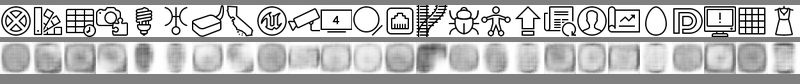

In [15]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [16]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

In [17]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

var_auto_encoder, decoder = VariationalAutoEncoder(32)
var_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 4)    40          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 4)    20          <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 32, 32, 8)    0           <tensorflow.python.keras.layers.c
                                                                 <tensorflow.python.keras.layers.c
__________

In [18]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           multiple                  147584    
_________________________________________________________________
up_sampling2d_10 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_43 (Conv2D)           multiple                  73792     
_________________________________________________________________
up_sampling2d_11 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_44 (Conv2D)           multiple                  18464     
__________

In [19]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train)
x_test_trunc = truncate_to_batch(x_test)
x_train_trunc.shape, x_test_trunc.shape

((5000, 32, 32, 1), (750, 32, 32, 1))

In [20]:
var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 5000 samples, validate on 750 samples
Epoch 1/100
5000/5000 [==============================] - 2s 357us/sample - loss: 0.5687 - KL_loss: 0.0012 - reconstruction_loss: 0.5676 - val_loss: 0.5150 - val_KL_loss: 2.5290e-04 - val_reconstruction_loss: 0.5147
Epoch 2/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.5067 - KL_loss: 2.1008e-04 - reconstruction_loss: 0.5065 - val_loss: 0.4952 - val_KL_loss: 2.0090e-04 - val_reconstruction_loss: 0.4950
Epoch 3/100
5000/5000 [==============================] - 0s 84us/sample - loss: 0.4923 - KL_loss: 3.6209e-04 - reconstruction_loss: 0.4919 - val_loss: 0.4828 - val_KL_loss: 9.6299e-04 - val_reconstruction_loss: 0.4818
Epoch 4/100
5000/5000 [==============================] - 0s 83us/sample - loss: 0.4839 - KL_loss: 0.0010 - reconstruction_loss: 0.4829 - val_loss: 0.4784 - val_KL_loss: 0.0010 - val_reconstruction_loss: 0.4774
Epoch 5/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.4809 - KL_

5000/5000 [==============================] - 0s 83us/sample - loss: 0.3970 - KL_loss: 0.0066 - reconstruction_loss: 0.3903 - val_loss: 0.3965 - val_KL_loss: 0.0065 - val_reconstruction_loss: 0.3900
Epoch 40/100
5000/5000 [==============================] - 0s 83us/sample - loss: 0.3957 - KL_loss: 0.0067 - reconstruction_loss: 0.3890 - val_loss: 0.3926 - val_KL_loss: 0.0069 - val_reconstruction_loss: 0.3857
Epoch 41/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.3941 - KL_loss: 0.0069 - reconstruction_loss: 0.3872 - val_loss: 0.3921 - val_KL_loss: 0.0069 - val_reconstruction_loss: 0.3852
Epoch 42/100
5000/5000 [==============================] - 0s 83us/sample - loss: 0.3931 - KL_loss: 0.0070 - reconstruction_loss: 0.3861 - val_loss: 0.3920 - val_KL_loss: 0.0069 - val_reconstruction_loss: 0.3851
Epoch 43/100
5000/5000 [==============================] - 0s 83us/sample - loss: 0.3924 - KL_loss: 0.0070 - reconstruction_loss: 0.3853 - val_loss: 0.3900 - val_KL_loss:

Epoch 78/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.3700 - KL_loss: 0.0076 - reconstruction_loss: 0.3624 - val_loss: 0.3731 - val_KL_loss: 0.0075 - val_reconstruction_loss: 0.3656
Epoch 79/100
5000/5000 [==============================] - 0s 83us/sample - loss: 0.3696 - KL_loss: 0.0075 - reconstruction_loss: 0.3621 - val_loss: 0.3737 - val_KL_loss: 0.0076 - val_reconstruction_loss: 0.3661
Epoch 80/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.3697 - KL_loss: 0.0075 - reconstruction_loss: 0.3622 - val_loss: 0.3740 - val_KL_loss: 0.0075 - val_reconstruction_loss: 0.3664
Epoch 81/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.3689 - KL_loss: 0.0075 - reconstruction_loss: 0.3614 - val_loss: 0.3719 - val_KL_loss: 0.0075 - val_reconstruction_loss: 0.3644
Epoch 82/100
5000/5000 [==============================] - 0s 82us/sample - loss: 0.3689 - KL_loss: 0.0076 - reconstruction_loss: 0.3613 - val_loss: 0.3722 -

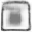

In [21]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


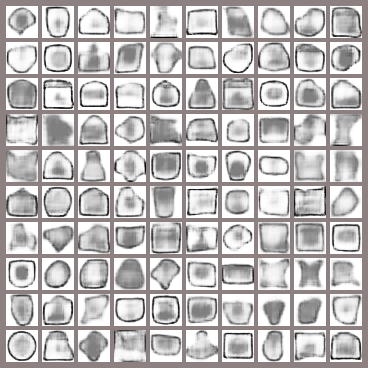

In [22]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.4 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [23]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train_aug)
x_test_trunc = truncate_to_batch(x_test_aug)
x_train_trunc.shape, x_test_trunc.shape

var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 83000 samples, validate on 14500 samples
Epoch 1/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3751 - KL_loss: 0.0077 - reconstruction_loss: 0.3674 - val_loss: 0.3710 - val_KL_loss: 0.0078 - val_reconstruction_loss: 0.3632
Epoch 2/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3697 - KL_loss: 0.0080 - reconstruction_loss: 0.3617 - val_loss: 0.3669 - val_KL_loss: 0.0081 - val_reconstruction_loss: 0.3588
Epoch 3/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3665 - KL_loss: 0.0081 - reconstruction_loss: 0.3585 - val_loss: 0.3653 - val_KL_loss: 0.0081 - val_reconstruction_loss: 0.3573
Epoch 4/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3639 - KL_loss: 0.0081 - reconstruction_loss: 0.3558 - val_loss: 0.3624 - val_KL_loss: 0.0082 - val_reconstruction_loss: 0.3543
Epoch 5/100
83000/83000 [==============================] - 7s 84us/sample - loss: 0.3620 - KL_loss: 0.

83000/83000 [==============================] - 7s 83us/sample - loss: 0.3334 - KL_loss: 0.0105 - reconstruction_loss: 0.3229 - val_loss: 0.3397 - val_KL_loss: 0.0102 - val_reconstruction_loss: 0.3296
Epoch 40/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3331 - KL_loss: 0.0105 - reconstruction_loss: 0.3225 - val_loss: 0.3348 - val_KL_loss: 0.0106 - val_reconstruction_loss: 0.3241
Epoch 41/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3324 - KL_loss: 0.0106 - reconstruction_loss: 0.3219 - val_loss: 0.3350 - val_KL_loss: 0.0107 - val_reconstruction_loss: 0.3243
Epoch 42/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3324 - KL_loss: 0.0106 - reconstruction_loss: 0.3217 - val_loss: 0.3346 - val_KL_loss: 0.0108 - val_reconstruction_loss: 0.3238
Epoch 43/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3320 - KL_loss: 0.0107 - reconstruction_loss: 0.3213 - val_loss: 0.3344 - va

83000/83000 [==============================] - 7s 83us/sample - loss: 0.3232 - KL_loss: 0.0117 - reconstruction_loss: 0.3115 - val_loss: 0.3264 - val_KL_loss: 0.0118 - val_reconstruction_loss: 0.3147
Epoch 78/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3229 - KL_loss: 0.0117 - reconstruction_loss: 0.3112 - val_loss: 0.3250 - val_KL_loss: 0.0116 - val_reconstruction_loss: 0.3134
Epoch 79/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3229 - KL_loss: 0.0117 - reconstruction_loss: 0.3111 - val_loss: 0.3266 - val_KL_loss: 0.0117 - val_reconstruction_loss: 0.3149
Epoch 80/100
83000/83000 [==============================] - 7s 83us/sample - loss: 0.3227 - KL_loss: 0.0118 - reconstruction_loss: 0.3109 - val_loss: 0.3254 - val_KL_loss: 0.0118 - val_reconstruction_loss: 0.3136
Epoch 81/100
83000/83000 [==============================] - 7s 85us/sample - loss: 0.3227 - KL_loss: 0.0118 - reconstruction_loss: 0.3110 - val_loss: 0.3250 - va

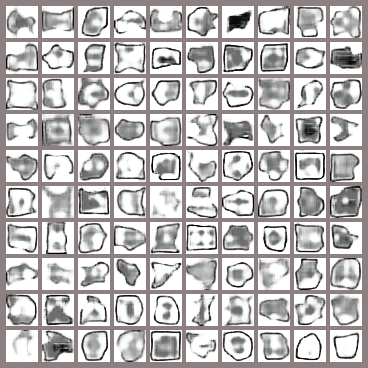

In [24]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.2 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

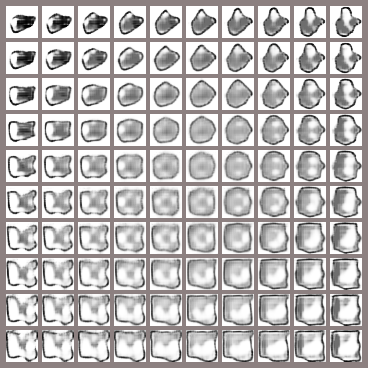

In [25]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [26]:
vec = np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])
vec.shape

(1, 128)

In [27]:
vec

array([[ 1.76209694, -1.90025609,  0.13684275,  0.42080388,  0.10453964,
        -0.25260731, -0.88713601,  0.66007471, -0.76613899,  0.25679253,
         1.43734309,  0.43360125, -0.45280359,  0.07204147, -0.46430789,
        -0.49765209, -0.96567623,  0.26959036, -0.65142072,  0.09915412,
        -0.20162719,  0.37352479, -0.07691914,  1.31351086,  0.39077831,
         0.18978925,  1.42750611, -0.32383646,  0.39101802,  0.28958188,
         0.20669965, -0.27080682, -0.3655856 , -0.6682818 ,  1.09271293,
         1.13824543,  0.05540307,  0.13847165,  0.14354865, -0.59538021,
        -0.49527155,  0.55296698, -0.41908343, -1.34588637, -0.5805215 ,
        -0.42793678,  0.23352881, -0.44786928, -1.10377371, -1.12111447,
        -1.60675697,  1.43391964, -0.627949  ,  2.96892872,  1.98596993,
         0.24453086, -1.2366206 ,  0.15100347, -1.59286274, -0.34923318,
         0.39668352,  1.5399453 , -0.5803638 , -1.87827176, -0.13028936,
         1.05301959,  0.57451167, -0.96549777, -0.1

In [28]:
np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])

array([[ 0.87281114,  0.27403872, -1.54972743,  0.7750884 ,  0.56065732,
         0.6842559 , -0.64138123, -0.05065898,  0.48234094,  0.41482878,
         0.94241439,  1.22693282,  1.19686119,  1.07459385, -1.4617889 ,
        -0.17214182,  0.28049339,  0.3777669 , -0.68407765,  1.94334641,
        -2.65207956,  0.85266493,  0.84929311,  0.15387909,  0.36074741,
        -1.49271924,  0.02360629,  0.33974666, -0.95684465, -1.078609  ,
        -0.75018537,  0.59532523, -1.00801086, -0.91006993, -1.12731458,
         0.04446357,  0.59712285,  0.50030818,  1.62102635, -0.76143985,
         0.1731896 ,  1.11462416, -0.09138966,  0.70047489,  0.69049665,
        -0.0784788 , -1.22276371,  0.28712634,  0.40044441, -0.03649943,
        -0.45818526, -1.47821337, -0.94696475, -0.30440826,  0.92008663,
         0.38166885,  0.16308266,  1.66927775,  1.25752385,  0.02469582,
        -1.29841953,  0.97326835, -0.14180164,  0.04594791,  0.27903984,
         0.23329479, -1.46070365,  0.15499239,  0.0